#**Classificação Room Type**



In [0]:
# imports

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/diogoflorencio/teste_cognitivo.ai/master/listings.csv')

# removing irrelevant columns
data = data.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'last_review'])

# droping rows where the target value is NA
data = data.dropna(subset=['room_type'])

# filling NA values with the average value of its respective column
data = data.fillna(data.median())

##**Análise descritiva e exploratória**

### **Sumarização**

In [3]:
data.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Copacabana,-22.96592,-43.17896,Entire home/apt,332,4,243,2.13,1,303
1,Copacabana,-22.97712,-43.19045,Entire home/apt,160,7,235,2.04,3,119
2,Ipanema,-22.98302,-43.21427,Entire home/apt,273,2,271,2.38,1,88
3,Ipanema,-22.98816,-43.19359,Entire home/apt,378,2,169,2.28,1,85
4,Copacabana,-22.98127,-43.19046,Entire home/apt,130,3,316,2.84,1,128


Através da função *describe* podemos analisar métricas de estatística descritiva que sumarizam medidas de tendência central e distribuição dos dados. Para as variáveis numéricas temos as seguintes informações:

* ***count*** representa a quantidade total de ocorrências;


* ***mean*** apresenta o valor médio dos valores daquela coluna;


* ***std*** corresponde ao desvio padrão;


* ***min*** e ***max*** exibem os valores mínimos e máximos, respectivamente, de cada coluna;


* ***25%, 50%*** e ***75%*** que representam os percentis.















In [4]:
# describe of numerical variables
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
latitude,33715.0,-22.965208,0.035244,-23.07340,-22.98471,-22.97085,-22.946725,-22.75038
longitude,33715.0,-43.254228,0.097488,-43.73709,-43.32336,-43.20022,-43.187085,-43.10406
price,33715.0,651.860537,1695.447098,0.00000,151.00000,290.00000,600.000000,41982.00000
minimum_nights,33715.0,4.789826,22.640328,1.00000,1.00000,2.00000,4.000000,1123.00000
number_of_reviews,33715.0,9.374344,24.815311,0.00000,0.00000,1.00000,6.000000,372.00000
reviews_per_month,33715.0,0.548576,0.722239,0.01000,0.25000,0.34000,0.460000,10.08000
calculated_host_listings_count,33715.0,5.996292,20.303420,1.00000,1.00000,1.00000,3.000000,205.00000
availability_365,33715.0,177.956251,149.766863,0.00000,0.00000,165.00000,350.000000,365.00000


O mesmo pode ser feito para as variáveis categóricas, onde: 

* ***count*** representa aqui também a quantidade total de ocorrências;

* ***unique*** apresenta a quantidade de valores possíveis (e.g. *room_type* apresenta 4 valores únicos: Entire home/apt, Private room, Shared room, Hotel room);

* ***top*** revela o valor mais comum entre todos os valores daquela coluna;

* ***freq*** mostra a frequência com a qual a variável mais comum aparece.











In [5]:
#describe of categorical variables
data.describe(include='O').transpose()

,count,unique,top,freq
neighbourhood,33715,153,Copacabana,8443
room_type,33715,4,Entire home/apt,23947


Copacabana é o bairro com o maior número de imóveis listados e *Entire home/apt* é o tipo de acomodação mais frequente.

### **Distribuição dos dados**

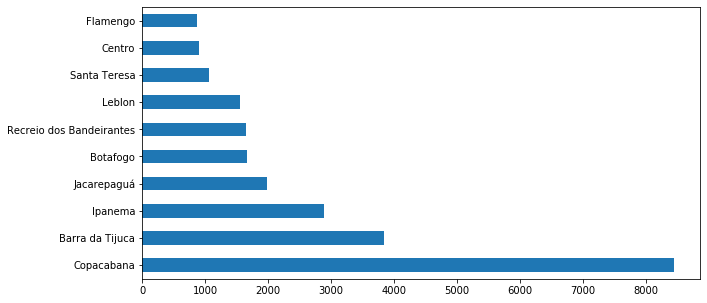

In [6]:
# plotting the 10 neigbourhoods that appear the most
fig, ax = plt.subplots(figsize=(10,5))
data.neighbourhood.value_counts().head(10).plot.barh()

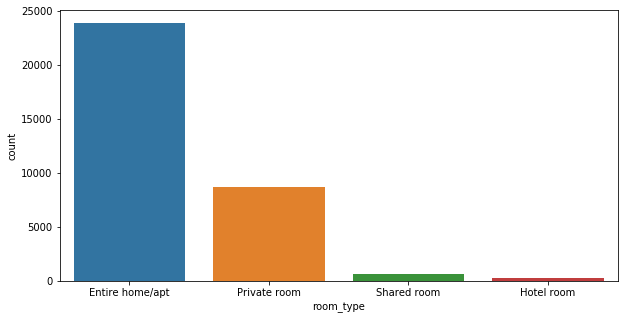

In [7]:
# plotting target variable distribution
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
sns.countplot(data['room_type'])

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem dos modelos. Isso pode ser tratrado por meio de técnicas de Under-sampling, neste caso vou utilizar a técnica NearMiss versão 2, que seleciona as amostras da classe majoritária para as quais a distância média até as N-amostras mais distantes da classe minoritária é a menor.

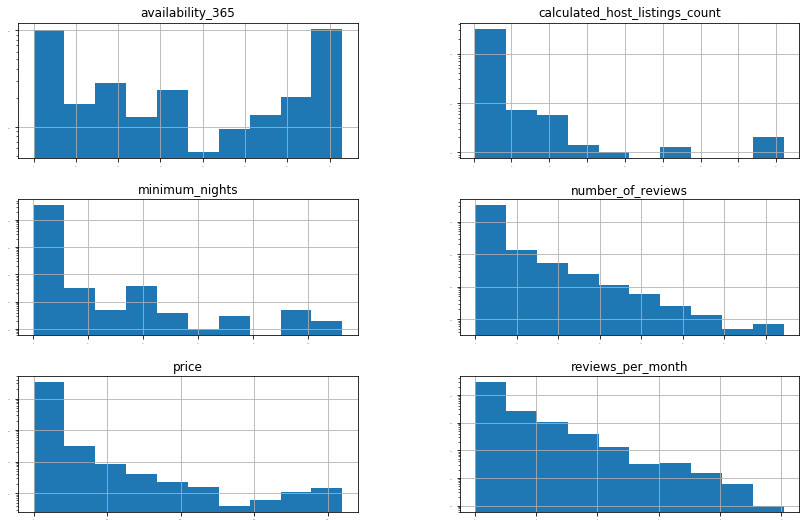

In [8]:
# plotting numerical variables histogram
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)

dist_feats = pd.DataFrame({ 'price':data['price'],
                            'minimum_nights':data['minimum_nights'],
                            'number_of_reviews':data['number_of_reviews'],
                            'reviews_per_month':data['reviews_per_month'],
                            'calculated_host_listings_count':data['calculated_host_listings_count'],
                            'availability_365':data['availability_365']
                          })

hits = dist_feats.hist(log=True, xlabelsize=0, ylabelsize=0)

Os dados apresentam escalas variadas com distribuições não Gaussianas, assim os mesmos devem ser normalizados.

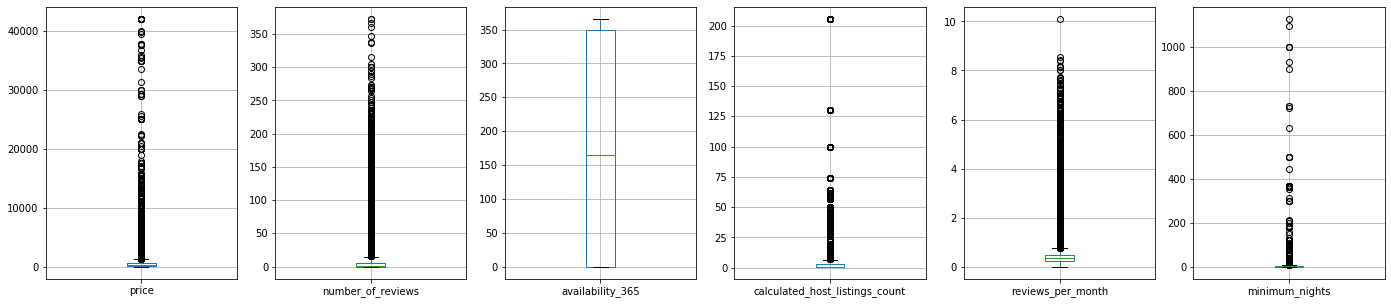

In [9]:
# plotting boxplots of numerical variables
fig, ax = plt.subplots(figsize=(24,5))
plt.subplot(1, 6, 1)
data.boxplot(column=['price'])
plt.subplot(1, 6, 2)
data.boxplot(column=['number_of_reviews'])
plt.subplot(1, 6, 3)
data.boxplot(column=['availability_365'])
plt.subplot(1, 6, 4)
data.boxplot(column=['calculated_host_listings_count'])
plt.subplot(1, 6, 5)
data.boxplot(column=['reviews_per_month'])
plt.subplot(1, 6, 6)
data.boxplot(column=['minimum_nights'])

Os boxplots acima exibem mais detalhes sobre a distribuição dos dados. 

Com execeção da variável `availability_365`, a amplitude ou intervalo interquartil (distância entre o terceiro e primeiro quartil) das demais é pequena, o que indica uma baixa variabilidade nos dados. Porém elas apresentam muitos *outliers*, o que contrasta, novamente, com o observado na variável `availability_365` que não contém outliers e apresenta uma maior variabilidade.

A posição da linha da mediana informa sobre a assimetria das distribuições, caso a linha esteja no centro do retângulo a distribuição é simétrica, o que não é o caso para nenhuma das variáveis. 

###**Engenharia de features**

In [0]:
# function that calculates Q1(lower_quartile), Q2(median), Q3(upper_quartile) and IQR (inter_quartile_range) for a given feature distribution
def boxplot_stats(data, feature):
  median = np.median(data[feature])
  upper_quartile = np.percentile(data[feature], 75)
  lower_quartile = np.percentile(data[feature], 25)
  inter_quartile_range = upper_quartile - lower_quartile

  return median, upper_quartile, lower_quartile, inter_quartile_range

**Preço por Bairro**

Com objetivo de categorizar a variável `price` com relação ao bairro, criamos a variável `price_per_neighbourhood` que classifica o preço das diárias como ***Low***, ***Regular*** ou ***High***. Para isso, analisamos a distribuição da variável `price` dentro de cada bairro e classificamos do seguinte modo:

* ***Low*** para valores abaixo do primeiro quartil;
* ***Regular*** para valores dentro do intervalo interquartil;
* ***High*** para valores acima do terceiro quartil.

In [0]:
# classifying price per neighbourhood
def price_level_per_neighbourhood(row):
  median, upper_quartile, lower_quartile, inter_quartile_range = boxplot_stats(data.loc[data['neighbourhood'] == row['neighbourhood']], 'price')
  return ('Low' if row["price"] <= lower_quartile else 'Regular' if row["price"] <= upper_quartile else 'High')

data['price_per_neighbourhood'] = data.apply(price_level_per_neighbourhood, axis=1) 

**Popularidade e Disponibilidade**

A mesma ideia foi aplicada para as variáveis `number_of_reviews` e `availability_365`, entretanto, dessa vez, não levou-se em consideração o bairro já que essas variáveis, semânticamente, descrevem medidas globais. 

Então, criamos as variáveis `popularity` e `availability` que classificam os imóveis de acordo com sua popularidade e disponibilidade, respectivamente. 

In [12]:
# creating popularity category
median, upper_quartile, lower_quartile, inter_quartile_range = boxplot_stats(data, 'number_of_reviews')
reviews_categories = data['number_of_reviews'].map(
    lambda number_of_reviews: 'Low' if number_of_reviews <= lower_quartile else 'Regular' if number_of_reviews <= upper_quartile else 'High')

data['popularity'] = reviews_categories

# creating availability category
median, upper_quartile, lower_quartile, inter_quartile_range = boxplot_stats(data,'availability_365')
availability_categories = data['availability_365'].map(
    lambda availability_365	: 'Low' if availability_365 <= lower_quartile else 'Regular' if availability_365 <= upper_quartile else 'High')

data['availability'] = availability_categories

data.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_neighbourhood,popularity,availability
0,Copacabana,-22.96592,-43.17896,Entire home/apt,332,4,243,2.13,1,303,Regular,High,Regular
1,Copacabana,-22.97712,-43.19045,Entire home/apt,160,7,235,2.04,3,119,Regular,High,Regular
2,Ipanema,-22.98302,-43.21427,Entire home/apt,273,2,271,2.38,1,88,Regular,High,Regular
3,Ipanema,-22.98816,-43.19359,Entire home/apt,378,2,169,2.28,1,85,Regular,High,Regular
4,Copacabana,-22.98127,-43.19046,Entire home/apt,130,3,316,2.84,1,128,Low,High,Regular


Os gráficos abaixo retratam a frequência de cada categoria para as variáveis `popularity` e `availability`.

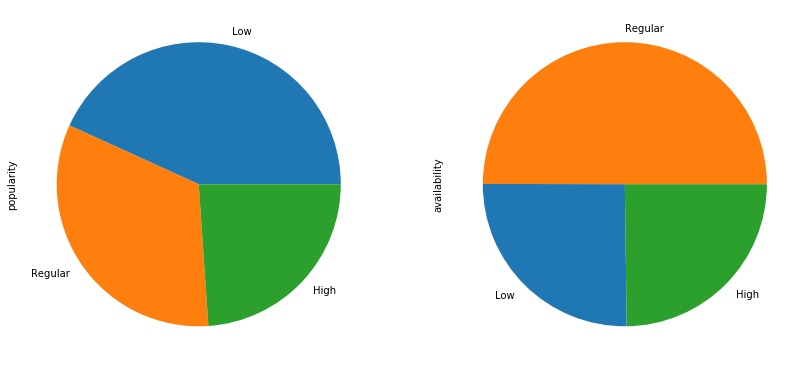

In [13]:
fig, ax =plt.subplots(1,2)
plt.subplot(1, 2, 1)
data['popularity'].value_counts().plot(kind='pie', colors = ['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.subplot(1, 2, 2)
data['availability'].value_counts().plot(kind='pie', colors = ['#ff7f0e', '#1f77b4', '#2ca02c'])

O gráfico de barras abaixo mostra a distribuição de preços nos bairros mais populares.

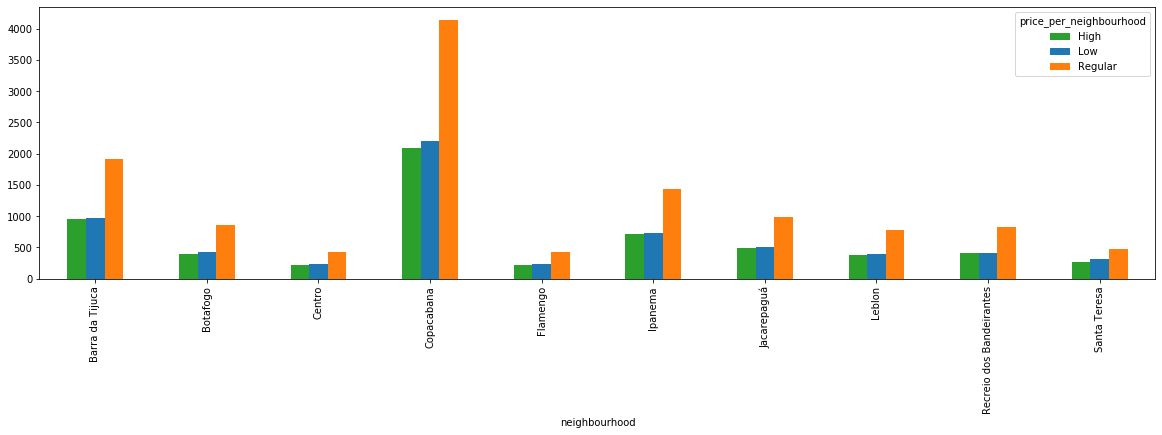

In [14]:
neighbourhood_data = data[['neighbourhood','price_per_neighbourhood']]
cnt = neighbourhood_data.neighbourhood.value_counts()
values = cnt[(cnt.index != 0) & (cnt >= 800)].index.values
popular_neighbourhood = neighbourhood_data.query("neighbourhood in @values")

matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)
popular_neighbourhood.pivot_table(index='neighbourhood', columns='price_per_neighbourhood', aggfunc=len, fill_value=0).plot(kind = 'bar', colors = ['#2ca02c', '#1f77b4', '#ff7f0e' ])

### **Modelagem Estatística**

**Normalização e Dummy**

In [0]:
# dummy of target variable, Entire home/apt = 0, Private room = 1, Shared room = 2, Hotel room =3
y = data['room_type'].replace(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'], [0, 1, 2, 3])

# removing target variable from the data
x = data.drop(columns=['room_type'])

# selecting numerical attributes
numeric_feats = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'] 

# normalizing numerical attributes
x[numeric_feats] = np.log1p(x[numeric_feats])

# categorical variables dummy
x = pd.get_dummies(x)

**Balanceamento da variável alvo**

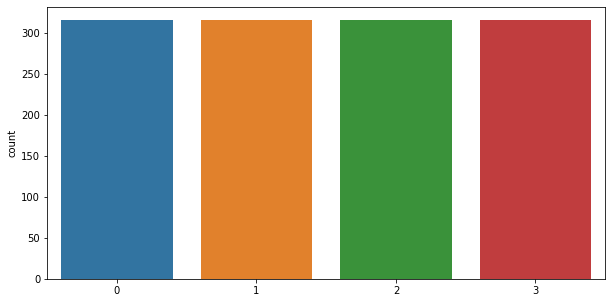

In [16]:
# balancing classes
nm = NearMiss(version=2)
x_balanced, y_balanced = nm.fit_resample(x, y)

# plotting target variable distribution
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
sns.countplot(y_balanced)

**Definindo conjunto de treino e teste**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.25, random_state=1)

### **Treinando e tuning dos modelos**

In [0]:
# function to calculate cross validation f1
def report_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5,  random_state=3058))
    return f1

**Logistic Regression**

O melhor alpha é 0.8000000000000003, com F1 = 0.6574285177182893


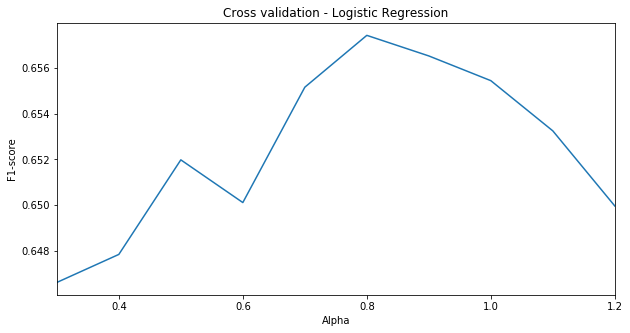

In [19]:
alphas = np.arange(0.3,1.3,0.1).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha), 
                         x_train, 
                         y_train).mean()
                    for alpha in alphas]
cv_logRegression = pd.Series(cv_logRegression, index = alphas)
# plotting f1 cross validation
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

**KNN**

A melhor quantidade de vizinhos é 10, com F1 = 0.7081255015901167


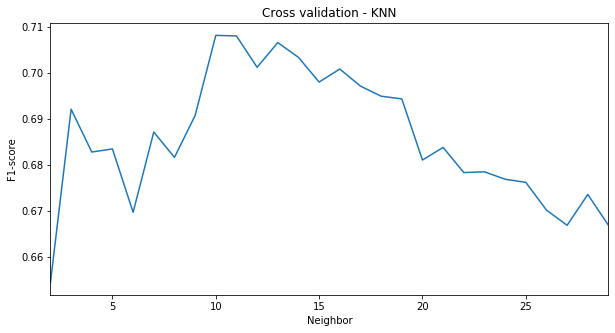

In [20]:
neighbors = np.arange(2,30,1).tolist()
cv_knn = [report_cv(KNeighborsClassifier(n_neighbors=neighbor),
               x_train,
               y_train).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)
# plotting f1 cross validation
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

**Decision Tree**

A profundidade máxima ideal é 9, com F1 = 0.7155790919012792


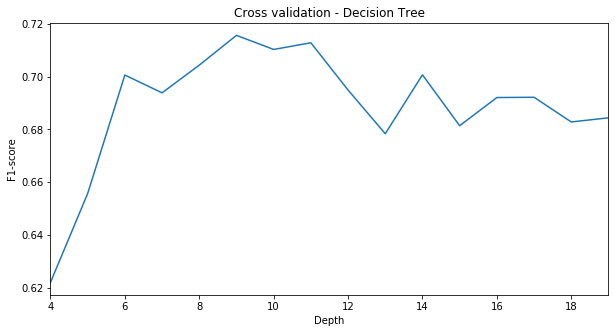

In [21]:
depths = np.arange(4,20,1).tolist()
cv_tree = [report_cv(DecisionTreeClassifier(max_depth = depth),
                x_train,
                y_train).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)
# plotting f1 cross validation
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

**Random Forest**

A quantidade de árvores ideal é 161, com F1 = 0.731003307604019


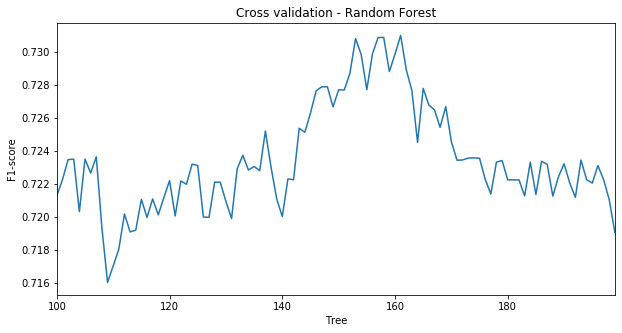

In [22]:
trees = np.arange(100,200,1).tolist()
cv_random_forest = [report_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_tree.idxmax(), random_state=0),
                         x_train,
                         y_train).mean() 
                    for tree in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)
# plotting f1 cross validation
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

**Adaboost**

A quantidade de árvores ideal é 44, com F1 = 0.7508336753336586


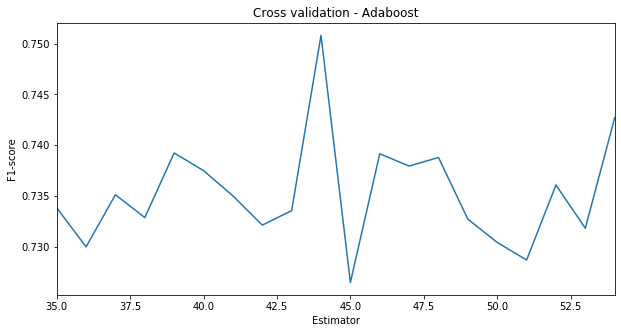

In [23]:
estimators = np.arange(35,55,1).tolist()
cv_ada =  [report_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
                x_train,
                y_train).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
# plotting f1 cross validation
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

### **Validação dos modelos**

In [0]:
# validating the models
def model_validation(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  report_validation = metrics.classification_report(y_test, y_pred, output_dict=True)["macro avg"] 

  #print metrics
  print("Precision = {0}".format(report_validation["precision"]))
  print("Recall = {0}".format(report_validation["recall"]))
  print("F1-Score = {0}".format(report_validation["f1-score"]))
  return

**Logistic Regression**

In [25]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax())
print("Logistic Regression")
model_validation(log_reg, x_train, y_train, x_test, y_test)

Logistic Regression
Precision = 0.666753936423054
Recall = 0.661103018242852
F1-Score = 0.6587184682511605


**KNN**

In [26]:
knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
print("KNN")
model_validation(knn, x_train, y_train, x_test, y_test)

KNN
Precision = 0.6971164637831305
Recall = 0.6751275313881132
F1-Score = 0.6809003425462565


**Decision Tree**

In [27]:
tree = DecisionTreeClassifier(max_depth = cv_tree.idxmax())
print("Decision Tree")
model_validation(tree, x_train, y_train, x_test, y_test)

Decision Tree
Precision = 0.7358599835420636
Recall = 0.7293554900796705
F1-Score = 0.7306360892628498


**Random Forest**

In [28]:
random_forest = RandomForestClassifier(n_estimators=cv_tree.idxmax().astype(int), max_depth=cv_random_forest.idxmax(), random_state=0)
print("Random Forest")
model_validation(random_forest, x_train, y_train, x_test, y_test)

Random Forest
Precision = 0.6995754245754245
Recall = 0.686282496683451
F1-Score = 0.6904225411041918


**AdaBoost**

In [29]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())
print("AdaBoost")
model_validation(ada, x_train, y_train, x_test, y_test)

AdaBoost
Precision = 0.7500706676504609
Recall = 0.7356835022757756
F1-Score = 0.7333686834369065


### **Relevância das features**

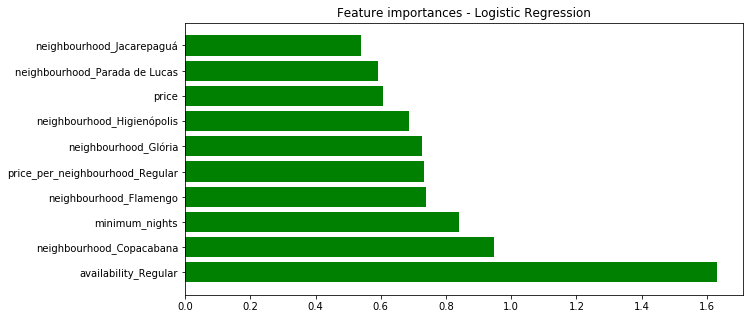

In [30]:
# Plot the feature importances of the Logistic Regression
importances = log_reg.coef_[0]
indices = np.argsort(importances)[::-1]
indices = indices[0:10]
plt.figure()
plt.title("Feature importances - Logistic Regression")
plt.barh(range(indices.size), importances[indices],
       color="g", tick_label=x.columns[indices], align="center")
plt.show()

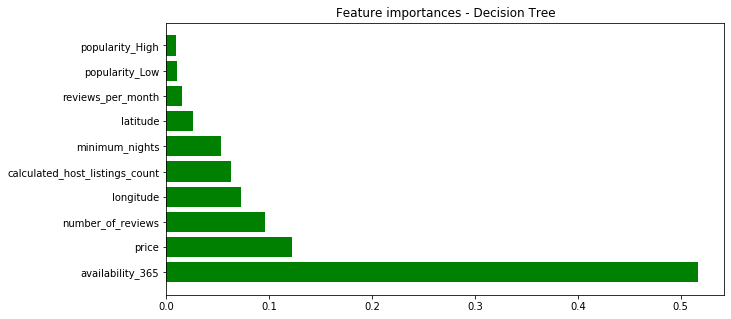

In [31]:
# Plot the feature importances of the Decision Tree
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[0:10]
plt.figure()
plt.title("Feature importances - Decision Tree")
plt.barh(range(indices.size), importances[indices],
       color="g", tick_label=x.columns[indices], align="center")
plt.show()

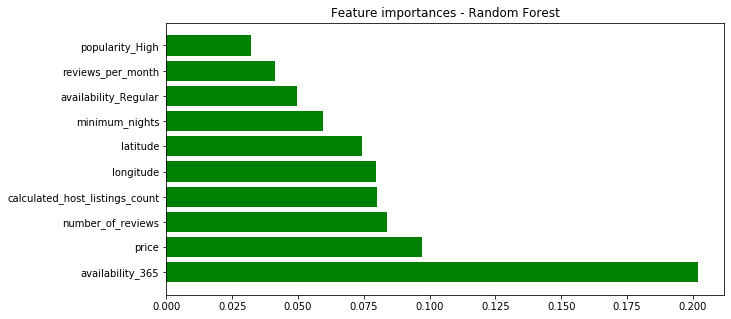

In [32]:
# Plot the feature importances of the Random Forest
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[0:10]
plt.figure()
plt.title("Feature importances - Random Forest")
plt.barh(range(indices.size), importances[indices],
       color="g", tick_label=x.columns[indices], align="center")
plt.show()

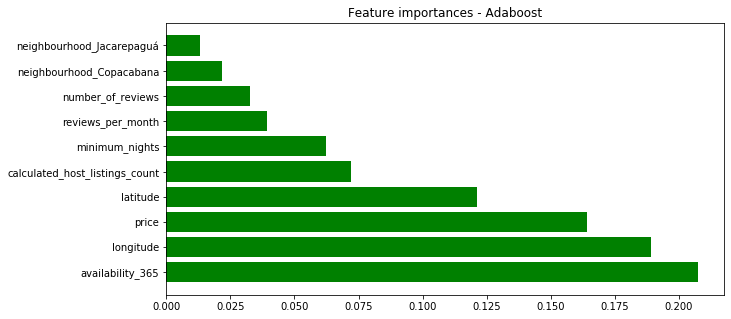

In [33]:
# Plot the feature importances of the adaboost
importances = ada.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[0:10]
plt.figure()
plt.title("Feature importances - Adaboost")
plt.barh(range(indices.size), importances[indices],
       color="g", tick_label=x.columns[indices], align="center")
plt.show()